In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from statistics import mean
import json
import ast

In [ ]:
PATH = '' # PATH TO COMPLETE

In [3]:
def read_midas(midas_filename:str):
    df = pd.read_csv(midas_filename)
    df.drop(columns=df.columns[0], axis=1, inplace=True)
    df = df[(df.filter(regex='^DA:.*') != 0).all(axis=1)]

    TR_cols = list(filter(lambda x: x.startswith('TR:'), df.columns))
    input_inter = df[TR_cols]
    input_inter.columns = input_inter.columns.str.replace('TR:', '')
    DV_cols = list(filter(lambda x: x.startswith('DV:'), df.columns))
    readouts = df[DV_cols]
    readouts.columns = readouts.columns.str.replace('DV:', '')
   
    return input_inter, readouts

In [ ]:

MEDIUM_CELL_NB = 348
LATE_CELL_NB = 332


medium_filename = f'{PATH}medium_TE_midas.csv'
late_filename = f'{PATH}late_TE_midas.csv'
perturbations_filename = f'{PATH}perturbations.json'
redundancies_filename = f'{PATH}redondancy_cells.json'
input_genes = ["SRPRA", "PLCG1", "MYCBP", "SMAD4", "SMAD3", "CREM", "E2F1"]
intermediate_genes = ["EGR1", "FHL2", "PITX2"]

input_inter, medium_readouts = read_midas(medium_filename)
_, late_readouts = read_midas(late_filename)


classes = ['M', 'L']

nb_input_inter = input_inter.shape[1]
nb_pert= input_inter.shape[0]
nb_readouts = medium_readouts.shape[1]
nb_genes = nb_input_inter+nb_readouts


perturbations = ast.literal_eval(open(perturbations_filename).read())
redundancies = json.load(open(redundancies_filename))

matrix = dict()

for i in range(len(perturbations)):
    matrix[i] = {"perturbations": perturbations[i]}
    for i_i in input_inter.columns:
        matrix[i][i_i] = []
    for readout in medium_readouts.columns:
        matrix[i][readout] = []


differencies = dict()
redundancies_sort = list()


for i in range(nb_pert):
    matrix[i]['medium_TE'] = round(len(redundancies["medium_TE"][str(i)])/MEDIUM_CELL_NB*100)
    matrix[i]['late_TE'] = round(len(redundancies["late_TE"][str(i)])/LATE_CELL_NB*100)
    matrix[i]['redundancies'] = (matrix[i]['medium_TE'] + matrix[i]['late_TE']) /2
    redundancies_sort.append(matrix[i]['redundancies'])

    for j in range(nb_input_inter):
        value = input_inter.iloc[i, j]
        i_i_name = input_inter.columns[j]
        matrix[i][i_i_name]  = [0,value,0]

    for j in range(nb_readouts):
        val1 = medium_readouts.iloc[i, j]
        val2 = late_readouts.iloc[i, j]
        readout_name = medium_readouts.columns[j]
        matrix[i][readout_name] = [val1, val2]

        # compute differencies_expression
        if not readout_name in differencies.keys():
            differencies[readout_name] = {
                'values': [abs(val1-val2)],
                'mean': 0
            }
        else:
            differencies[readout_name]['values'].append(abs(val1-val2))

for key,values in differencies.items():
    values['mean'] = mean(values["values"])

sorted_readouts = sorted(differencies.items(), key=lambda item: item[1]["mean"], reverse=True)

sorted_readouts = [item[0] for item in sorted_readouts]


sorted_perturbations = sorted(matrix.items(), key=lambda item: item[1]["redundancies"], reverse=True)
sorted_perturbations = [item[0] for item in sorted_perturbations]


medium_readouts = medium_readouts[sorted_readouts]
late_readouts = late_readouts[sorted_readouts]


input_inter['redundancies_sort'] = redundancies_sort
input_inter = input_inter.set_index("redundancies_sort")
input_inter = input_inter.sort_index(ascending=False)



medium_readouts['redundancies_sort'] = redundancies_sort
medium_readouts = medium_readouts.set_index("redundancies_sort")
medium_readouts = medium_readouts.sort_index(ascending=False)

late_readouts['redundancies_sort'] = redundancies_sort
late_readouts = late_readouts.set_index("redundancies_sort")
late_readouts = late_readouts.sort_index(ascending=False)


fig = plt.figure(constrained_layout=True, figsize=(100, 35))

subfigs = fig.subfigures(1, 2, width_ratios=[25,75])

axs = subfigs[0].subplots(nb_pert, nb_input_inter)

for i in range(nb_pert):
    classes = ['M', 'L']
    for j in range(nb_input_inter):
        ax = axs[i, j]
        value = input_inter.iloc[i, j]
        ax.bar([1,2,3], [0,value,0], color='black')
        ax.set_frame_on(False)
        ax.set_xticks([]) 
        ax.set_yticks([])
        ax.set_ylim([0,1])
        if i == 0:
            gene_name = input_inter.columns[j]
            ax.set_xlabel(gene_name, fontsize = 70, weight='bold', rotation=90, labelpad=50)
            ax.xaxis.set_label_position('top')
            if gene_name in input_genes:
                ax.xaxis.label.set_color('#9ACD32')
            else:
                ax.xaxis.label.set_color('#FF4500')

axs = subfigs[1].subplots(nb_pert, nb_readouts)


for i in range(nb_pert):
    for j in range(nb_readouts):
        ax = axs[i, j]
        val1 = medium_readouts.iloc[i, j]
        val2 = late_readouts.iloc[i, j]
        ax.plot(classes, [val1, val2], linewidth=5, color='#ADD8E6')
        ax.set_ylim([0,1])
        if j != nb_readouts-1:
            ax.set_yticks([])
        else:
            ax.yaxis.set_label_position("right")
            ax.yaxis.tick_right()
        if i == 0:
            ax.set_xlabel(medium_readouts.columns[j], fontsize = 70, weight='bold', rotation=90, labelpad=50)
            ax.xaxis.set_label_position('top')

            ax.xaxis.label.set_color('#ADD8E6')
        
        if i != nb_pert-1:
            ax.set_xticks([])

        # compute differencies_expression
        gene_name = medium_readouts.columns[j]
        if not gene_name in differencies.keys():
            differencies[gene_name] = {
                'values': [abs(val1-val2)],
                'mean': 0
            }
        else:
            differencies[gene_name]['values'].append(abs(val1-val2))
for key,values in differencies.items():
    values['mean'] = mean(values["values"])

plt.savefig(f"{PATH}/pseudo-perturbation_visu_modified.png")





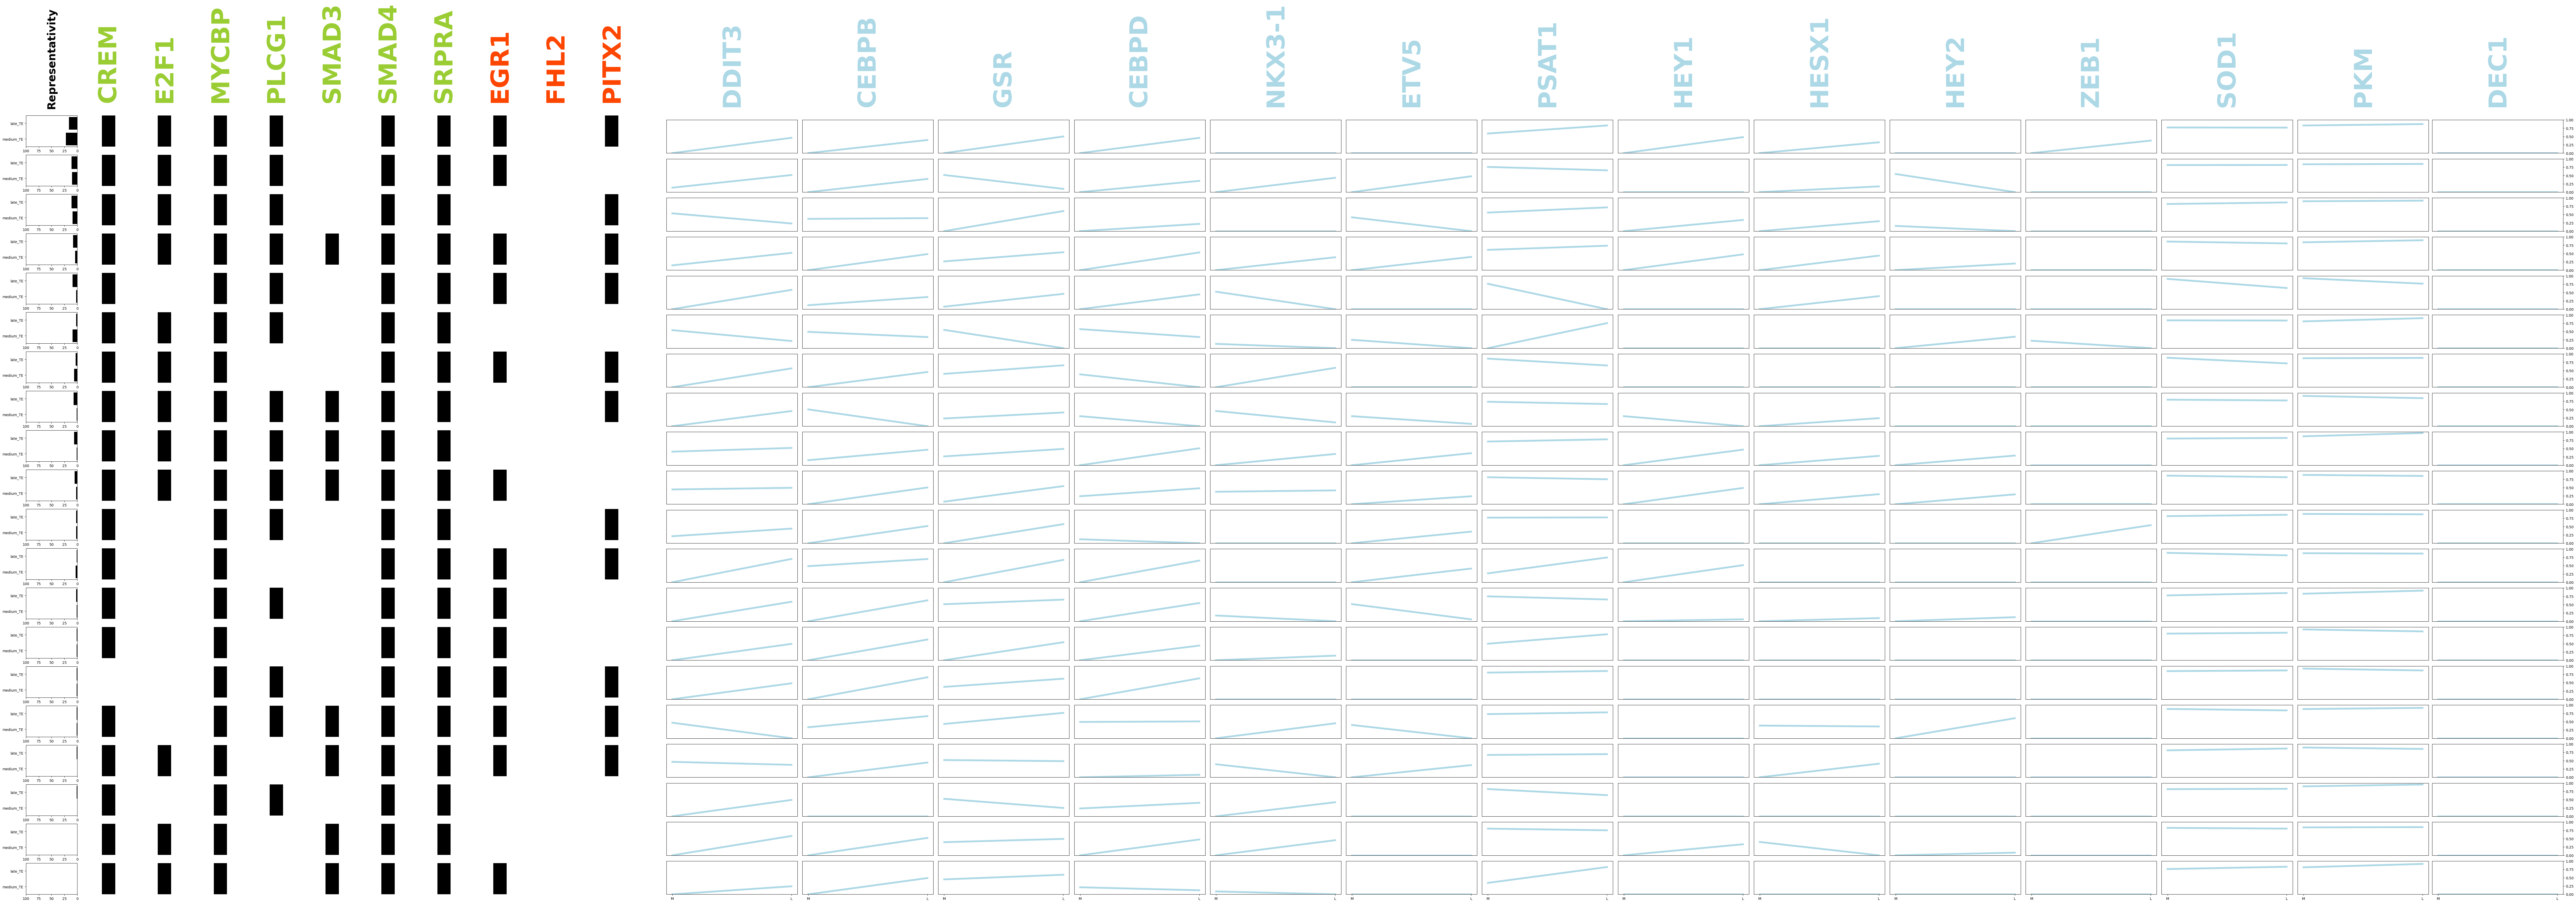

In [5]:
MEDIUM_CELL_NB = 348
LATE_CELL_NB = 332


medium_filename = f'{PATH}medium_TE_midas.csv'
late_filename = f'{PATH}late_TE_midas.csv'
perturbations_filename = f'{PATH}perturbations.json'
redundancies_filename = f'{PATH}redondancy_cells.json'
input_genes = ["SRPRA", "PLCG1", "MYCBP", "SMAD4", "SMAD3", "CREM", "E2F1"]
intermediate_genes = ["EGR1", "FHL2", "PITX2"]

input_inter, medium_readouts = read_midas(medium_filename)
_, late_readouts = read_midas(late_filename)


classes = ['M', 'L']

nb_input_inter = input_inter.shape[1]
nb_pert= input_inter.shape[0]
nb_readouts = medium_readouts.shape[1]
nb_genes = nb_input_inter+nb_readouts


perturbations = ast.literal_eval(open(perturbations_filename).read())
redundancies = json.load(open(redundancies_filename))

matrix = dict()

for i in range(len(perturbations)):
    matrix[i] = {"perturbations": perturbations[i]}
    for i_i in input_inter.columns:
        matrix[i][i_i] = []
    for readout in medium_readouts.columns:
        matrix[i][readout] = []


differencies = dict()
redundancies_sort = list()


for i in range(nb_pert):
    matrix[i]['medium_TE'] = round(len(redundancies["medium_TE"][str(i)])/MEDIUM_CELL_NB*100)
    matrix[i]['late_TE'] = round(len(redundancies["late_TE"][str(i)])/LATE_CELL_NB*100)
    matrix[i]['redundancies'] = (matrix[i]['medium_TE'] + matrix[i]['late_TE']) /2
    redundancies_sort.append(matrix[i]['redundancies'])

    for j in range(nb_input_inter):
        value = input_inter.iloc[i, j]
        i_i_name = input_inter.columns[j]
        matrix[i][i_i_name]  = [0,value,0]

    for j in range(nb_readouts):
        val1 = medium_readouts.iloc[i, j]
        val2 = late_readouts.iloc[i, j]
        readout_name = medium_readouts.columns[j]
        matrix[i][readout_name] = [val1, val2]

        # compute differencies_expression
        if not readout_name in differencies.keys():
            differencies[readout_name] = {
                'values': [abs(val1-val2)],
                'mean': 0
            }
        else:
            differencies[readout_name]['values'].append(abs(val1-val2))

for key,values in differencies.items():
    values['mean'] = mean(values["values"])

sorted_readouts = sorted(differencies.items(), key=lambda item: item[1]["mean"], reverse=True)

sorted_readouts = [item[0] for item in sorted_readouts]


sorted_perturbations = sorted(matrix.items(), key=lambda item: item[1]["redundancies"], reverse=True)
sorted_perturbations = [item[0] for item in sorted_perturbations]


medium_readouts = medium_readouts[sorted_readouts]
late_readouts = late_readouts[sorted_readouts]

input_inter['redundancies_sort'] = redundancies_sort
input_inter = input_inter.set_index("redundancies_sort")
input_inter = input_inter.sort_index(ascending=False)



medium_readouts['redundancies_sort'] = redundancies_sort
medium_readouts = medium_readouts.set_index("redundancies_sort")
medium_readouts = medium_readouts.sort_index(ascending=False)

late_readouts['redundancies_sort'] = redundancies_sort
late_readouts = late_readouts.set_index("redundancies_sort")
late_readouts = late_readouts.sort_index(ascending=False)


fig = plt.figure(constrained_layout=True, figsize=(100, 35))

subfigs = fig.subfigures(1, 2, width_ratios=[25,75])

axs = subfigs[0].subplots(nb_pert, nb_input_inter+1)

for i in range(nb_pert):
    
    ax = axs[i,0]
    ax.set_xlim([100,0])
    classes = ['medium_TE', 'late_TE']
    redundancies = [matrix[sorted_perturbations[i]]['medium_TE'], matrix[sorted_perturbations[i]]['late_TE']]
    ax.barh(classes, redundancies, color=['black', 'black'])
    if i == 0:
            ax.set_xlabel("Representativity", fontsize = 30, weight='bold', rotation=90, labelpad=25)
            ax.xaxis.set_label_position('top')
    classes = ['M', 'L']
    for j in range(nb_input_inter):
        ax = axs[i, j+1]
        value = input_inter.iloc[i, j]
        ax.bar([1,2,3], [0,value,0], color='black')
        ax.set_frame_on(False)
        ax.set_xticks([])  
        ax.set_yticks([])
        ax.set_ylim([0,1])
        if i == 0:
            gene_name = input_inter.columns[j]
            ax.set_xlabel(gene_name, fontsize = 70, weight='bold', rotation=90, labelpad=50)
            ax.xaxis.set_label_position('top')
            if gene_name in input_genes:
                ax.xaxis.label.set_color('#9ACD32')
            else:
                ax.xaxis.label.set_color('#FF4500')

axs = subfigs[1].subplots(nb_pert, nb_readouts)


for i in range(nb_pert):
    for j in range(nb_readouts):
        ax = axs[i, j]
        val1 = medium_readouts.iloc[i, j]
        val2 = late_readouts.iloc[i, j]
        ax.plot(classes, [val1, val2], linewidth=5, color='#ADD8E6')
        ax.set_ylim([0,1])
        if j != nb_readouts-1:
            ax.set_yticks([])
        else:
            ax.yaxis.set_label_position("right")
            ax.yaxis.tick_right()
        if i == 0:
            ax.set_xlabel(medium_readouts.columns[j], fontsize = 70, weight='bold', rotation=90, labelpad=50)
            ax.xaxis.set_label_position('top')

            ax.xaxis.label.set_color('#ADD8E6')
        
        if i != nb_pert-1:
            ax.set_xticks([])

        # compute differencies_expression
        gene_name = medium_readouts.columns[j]
        if not gene_name in differencies.keys():
            differencies[gene_name] = {
                'values': [abs(val1-val2)],
                'mean': 0
            }
        else:
            differencies[gene_name]['values'].append(abs(val1-val2))
for key,values in differencies.items():
    values['mean'] = mean(values["values"])

plt.savefig(f"{PATH}/pseudo-perturbation_visu_with_representativity.png")
